In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import mst_decoder as decoder
import mst_decoder.simulate as sim

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

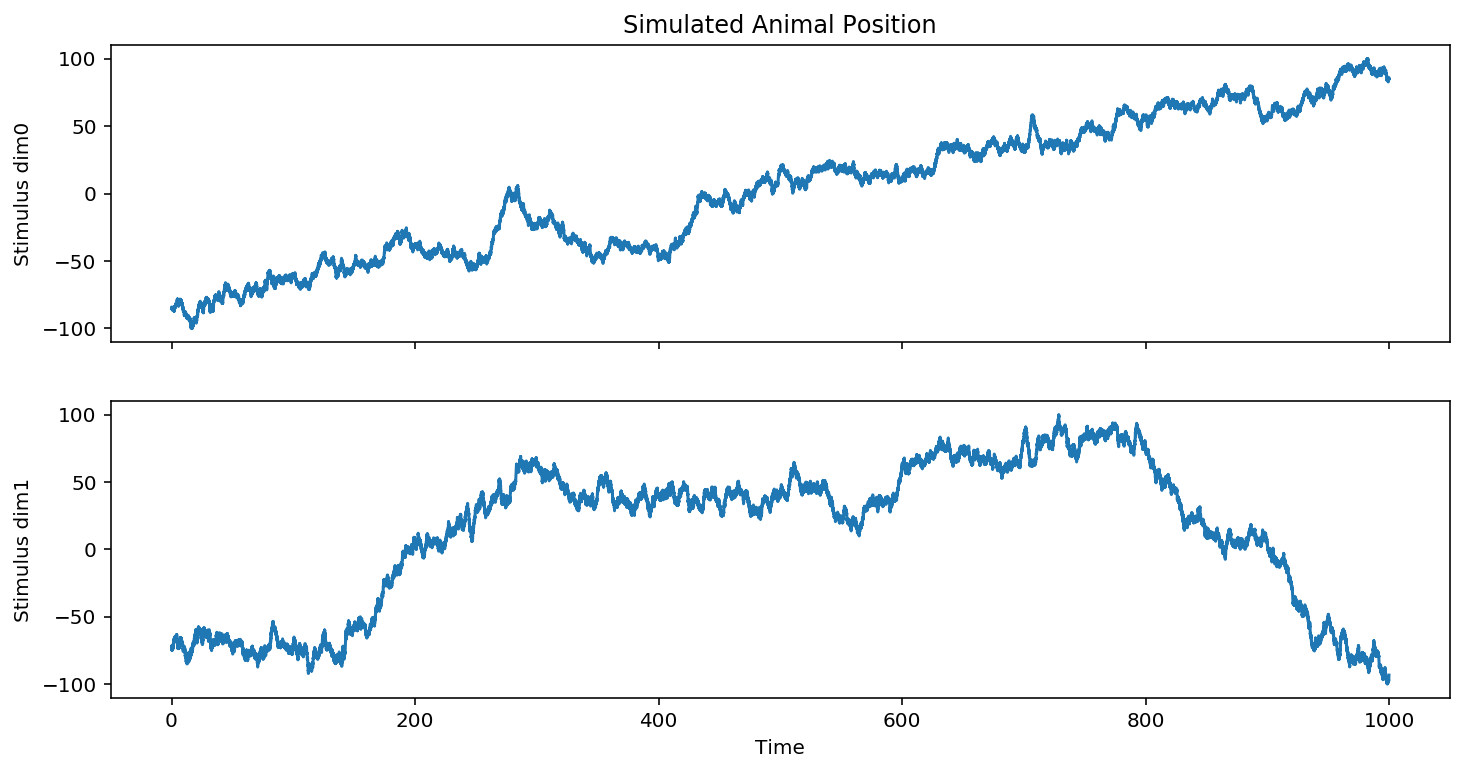

In [214]:
SAMPLING_FREQUENCY = 50
N_SAMPLES = SAMPLING_FREQUENCY * 1000

time = sim.simulate_time(N_SAMPLES, SAMPLING_FREQUENCY)
stimulus = sim.simulate_circular_cartesian(time, radius=50)
stimulus = sim.simulate_nd_randomwalk(time, bounds=np.array([[-100, 100], [-100, 100]]), delta=15)

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
axes[0].plot(time, stimulus[:, 0]);
axes[1].plot(time, stimulus[:, 1]);
axes[0].set_ylabel('Stimulus dim0')
axes[1].set_ylabel('Stimulus dim1')
axes[1].set_xlabel('Time')
axes[0].set_title('Simulated Animal Position');

/home/mz/prj/mst-decoder/mst_decoder/simulate.py:76: RuntimeWarning: Mean of empty slice


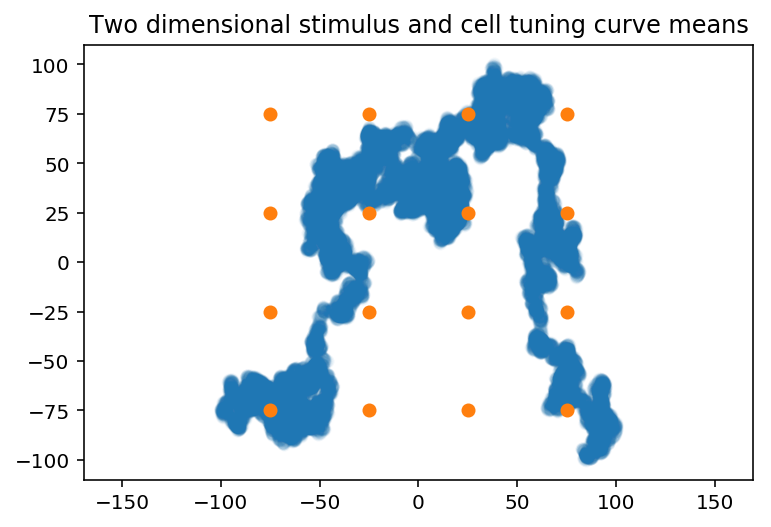

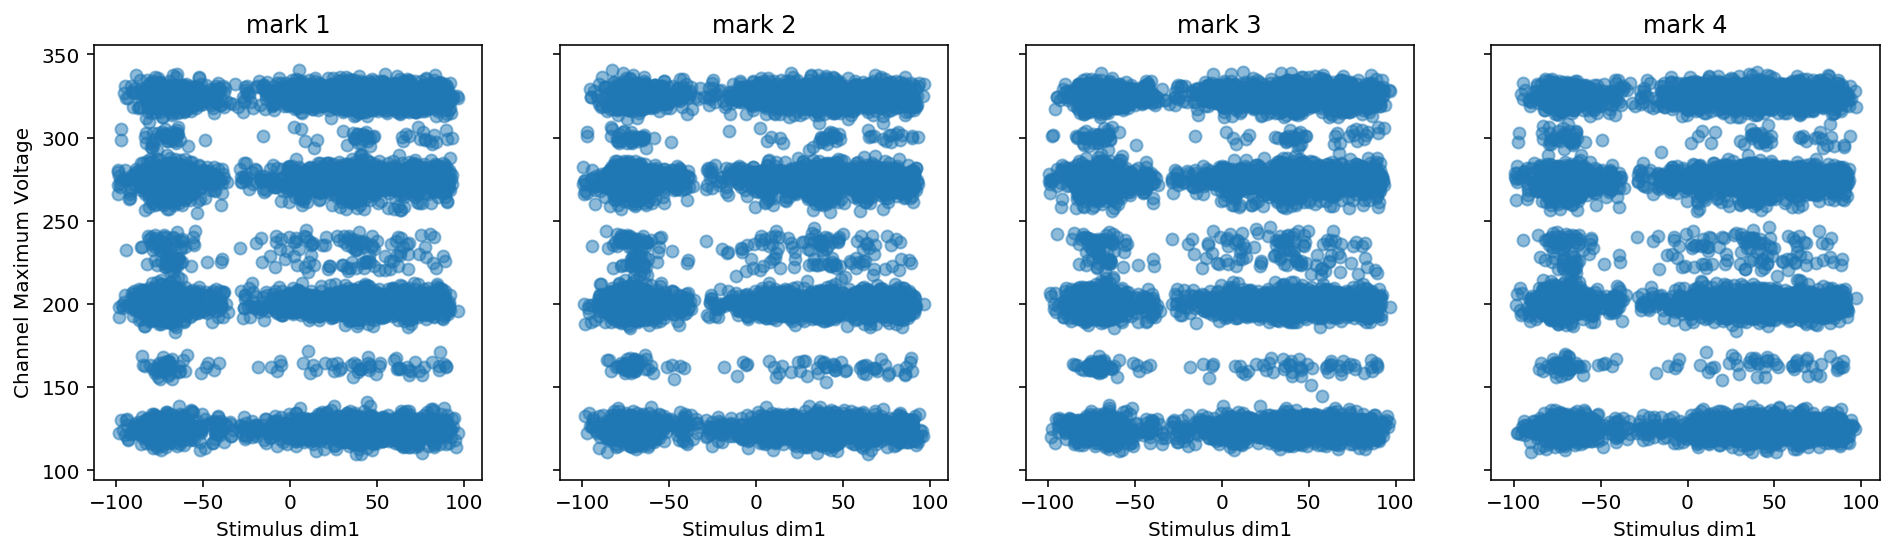

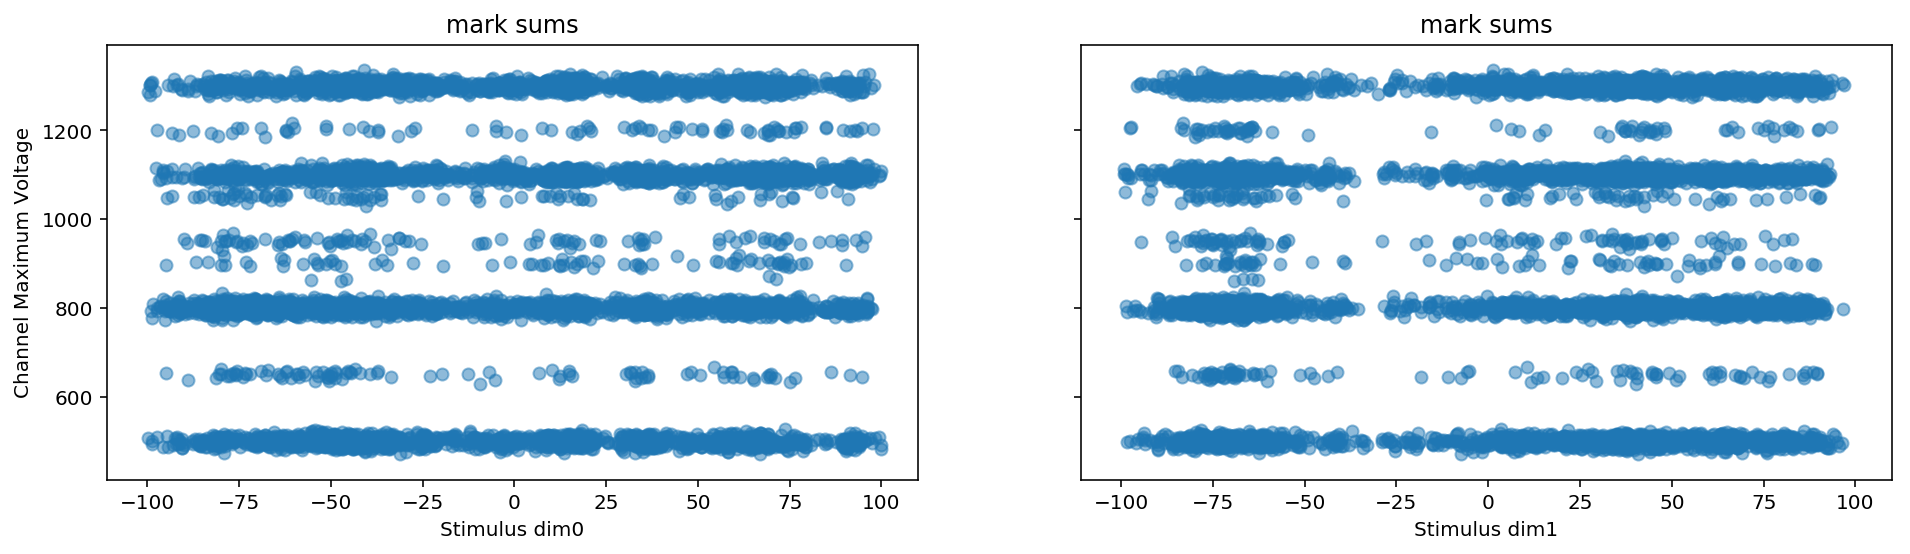

In [215]:
N_CELLS = 20

tuning_curve_means = sim.generate_gridded_tuning_curve_means(N_CELLS, stimulus)
mark_means = np.array([200, 125, 325, 275])
signal_data = [sim.simulate_multiunit(tuning_curve_means, mark_means, stimulus, SAMPLING_FREQUENCY)]

ax = plt.figure().gca()
ax.axis('equal')
ax.scatter(stimulus[:, 0], stimulus[:, 1], alpha=0.05);
ax.scatter(tuning_curve_means[:, 0], tuning_curve_means[:, 1])
ax.set_title('Two dimensional stimulus and cell tuning curve means')

for s in signal_data:
    fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16, 4))
    for ind, (ax, m) in enumerate(zip(axes, s.T)):
        ax.scatter(stimulus[:, 1], m, alpha=0.5)
        ax.set_xlabel('Stimulus dim1')
        ax.set_title('mark {0}'.format(ind + 1))
    axes[0].set_ylabel('Channel Maximum Voltage');
    fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(16, 4))
    axes[0].scatter(stimulus[:, 0], np.sum(s, axis=-1), alpha=0.5)
    axes[0].set_xlabel('Stimulus dim0')
    axes[0].set_title('mark sums'.format(ind + 1))
    axes[1].scatter(stimulus[:, 1], np.sum(s, axis=-1), alpha=0.5)
    axes[1].set_xlabel('Stimulus dim1')
    axes[1].set_title('mark sums'.format(ind + 1))
    axes[0].set_ylabel('Channel Maximum Voltage');

In [216]:
d = decoder.ClusterlessDecoder(
    stimulus=stimulus,
    spike_marks=signal_data)

# 7.38 s ± 50.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) single tetrode 20 cells
d.fit()

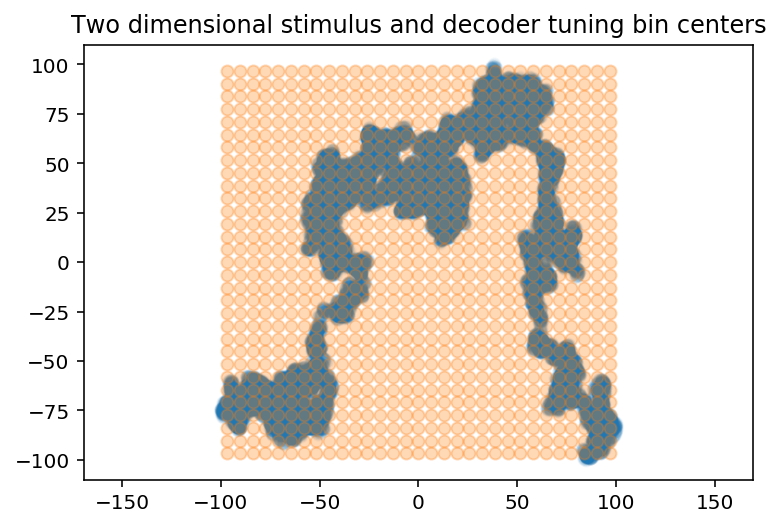

In [217]:
ax = plt.figure().gca()
ax.axis('equal')
ax.scatter(stimulus[:, 0], stimulus[:, 1], alpha=0.05);
ax.scatter(d.tuning_bin_grid[:, 0], d.tuning_bin_grid[:, 1], alpha=0.3);
ax.set_title('Two dimensional stimulus and decoder tuning bin centers');

In [218]:
d.plot_observation_model();

KeyError: 'signal'

In [223]:
mark_means_test = np.array([195, 130, 300, 265])
signal_data = [sim.simulate_multiunit(tuning_curve_means, mark_means_test, stimulus, SAMPLING_FREQUENCY)]

/home/mz/prj/mst-decoder/mst_decoder/simulate.py:76: RuntimeWarning: Mean of empty slice


In [49]:
mi = d.marginalized_intensities().sum('mark_dimension')

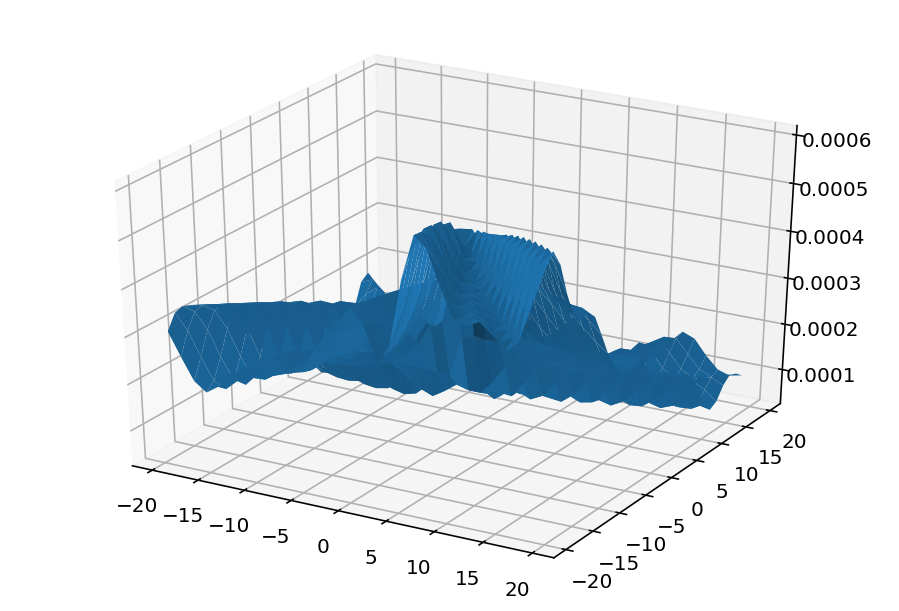

In [71]:
from mpl_toolkits.mplot3d import axes3d, Axes3D

x = d.tuning_bin_grid[:, 0].reshape(31, 31)
y = d.tuning_bin_grid[:, 1].reshape(31, 31)
z = mi.loc[dict(marks=slice(200,300))].mean('marks').values.reshape(31, 31)

fig = plt.figure()
ax = Axes3D(fig)

ax.plot_surface(x, y, z)

In [ ]:
res = d.predict(signal_data)

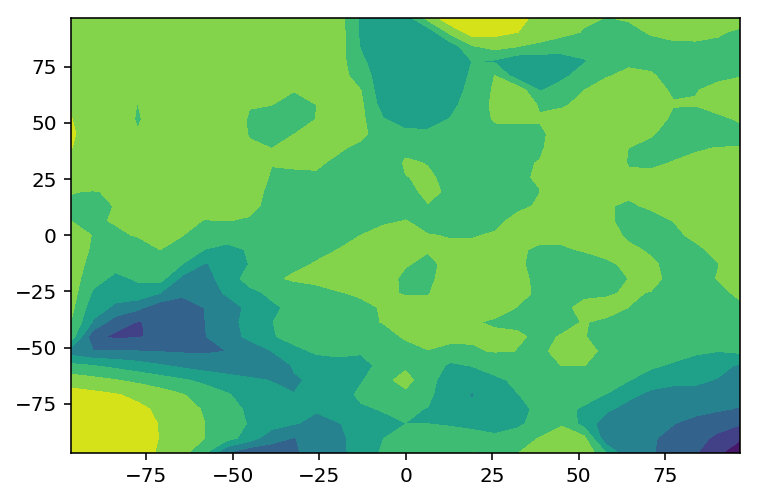

In [219]:
plt.contourf(d.tuning_bin_centers[0], d.tuning_bin_centers[1], 
             res.sel(time=25)['likelihood'].values.reshape(31, 31))

In [ ]:
%matplotlib inline
from matplotlib import animation, rc
from IPython.display import HTML
fig,ax = plt.subplots()

def animate(i):
    ax.clear()
    ax.contourf(d.tuning_bin_centers[0], d.tuning_bin_centers[1], 
             res['likelihood'][i].values.reshape(31, 31))
    xy = stimulus[i]
#     x = kde.axes[1].shape[0] * (xy[0] - np.min(kde.axes[1])) / (np.max(kde.axes[1])- np.min(kde.axes[1]))
#     y = kde.axes[2].shape[0] * (xy[1] - np.min(kde.axes[2])) / (np.max(kde.axes[2])- np.min(kde.axes[2]))
    ax.scatter(xy[0], xy[1], c='white', s=20)
    ax.set_title('%03d'%(i)) 
    return ax

interval = 0.05#in seconds     
ani = animation.FuncAnimation(fig,animate,res['time'].shape[0] // 100,interval=interval*1e+3,blit=False)

HTML(ani.to_html5_video())